In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from transformers import BertTokenizer, BertModel

c:\Users\Juan Felipe\Documents\GitHub\techspere_data_challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

## Construción embbeding medio

In [82]:
# 1. Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# 2. Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [83]:
# 3. Tokenizar ejemplo
text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt").to(device)

In [84]:
# 4. Obtener SOLO embeddings de tokens (sin positional encoding)
with torch.no_grad():
    token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])

In [85]:
# 5. Eliminar dimensión batch → (n_tokens, d_model)
token_matrix = token_embeddings.squeeze(0)

# 6. Calcular embedding promedio en GPU
mean_embedding = token_matrix.mean(dim=0)   # (d_model,)
print("Mean embedding shape:", mean_embedding.shape)

Mean embedding shape: torch.Size([768])


In [86]:
mean_embedding.shape, mean_embedding.dtype

(torch.Size([768]), torch.float32)

In [190]:
df = pd.read_csv("dataset.csv", sep=";")

In [191]:
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

In [198]:
# Supongamos que tu DataFrame se llama df
# Filtramos solo las filas con los grupos que nos interesan
valid_groups = ["cardiovascular", "neurological", "hepatorenal", "oncological"]
df_filtered = df[df["group"].isin(valid_groups)].copy()

# Definir X (texto) e y (labels)
X = df_filtered["text"].values
y = df_filtered["group"].values

print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)
print("Clases presentes:", set(y))


Tamaño de X: (2473,)
Tamaño de y: (2473,)
Clases presentes: {'oncological', 'hepatorenal', 'neurological', 'cardiovascular'}


In [199]:
def get_mean_embedding(text):
    # Tokenización y envío a GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        # SOLO token embeddings, sin positional encoding
        token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])
        token_matrix = token_embeddings.squeeze(0)       # (n_tokens, d_model)
        mean_embedding = token_matrix.mean(dim=0)        # (d_model,)
    return mean_embedding.cpu().numpy()  # traer a CPU como numpy

In [200]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# ======================
# 4. Construir X (mean embedding)
# ======================

X = np.vstack([get_mean_embedding(text) for text in df_filtered["text"].values])
print("Shape de X:", X.shape)  # (num_samples, d_model=768)

# ======================
# 5. Construir y (one-hot encoding)
# ======================
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df_filtered["group"].values.reshape(-1, 1))

print("Shape de y:", y.shape)  # (num_samples, num_classes=4)
print("Clases:",valid_groups)

Shape de X: (2473, 768)
Shape de y: (2473, 4)
Clases: ['cardiovascular', 'neurological', 'hepatorenal', 'oncological']


## Model

In [203]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LinearSVC es inherentemente binario, por lo que necesita el wrapper OneVsRest
# El parámetro 'C' también controla la regularización, similar a LogisticRegression
# 'dual=True' es a menudo recomendado cuando n_samples > n_features, pero prueba con ambos.
svc_clf = OneVsRestClassifier(LinearSVC(dual=True, random_state=42, max_iter=2000,C=15,tol=0.7,multi_class="crammer_singer"))

# Entrenar el modelo
svc_clf.fit(X_train, y_train)

# Predecir y evaluar
y_pred = svc_clf.predict(X_test)


In [204]:
predict=svc_clf.predict(X_train)
accuracy=accuracy_score(y_train,predict)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en train")

el modelo presenta un accuracy de 0.8798% en train


In [205]:
accuracy=accuracy_score(y_pred,y_test)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en test")

el modelo presenta un accuracy de 0.8558% en test


In [206]:
# Calcular F1-Score Ponderado (métrica principal del challenge)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Métrica Principal - F1 Score Ponderado (Weighted): {weighted_f1:.4f}\n")

# Reporte de clasificación completo (muestra métricas por cada clase)
print("Reporte de Clasificación Detallado (por clase):")
# Usamos `target_names` para que el reporte muestre los nombres de las clases
print(classification_report(y_test, y_pred, target_names=all_labels))


Métrica Principal - F1 Score Ponderado (Weighted): 0.9025

Reporte de Clasificación Detallado (por clase):
                precision    recall  f1-score   support

cardiovascular       0.99      0.84      0.91       192
   hepatorenal       0.99      0.82      0.90       175
  neurological       0.90      0.94      0.92       301
   oncological       1.00      0.69      0.82        74

     micro avg       0.95      0.86      0.90       742
     macro avg       0.97      0.82      0.89       742
  weighted avg       0.96      0.86      0.90       742
   samples avg       0.86      0.86      0.86       742



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


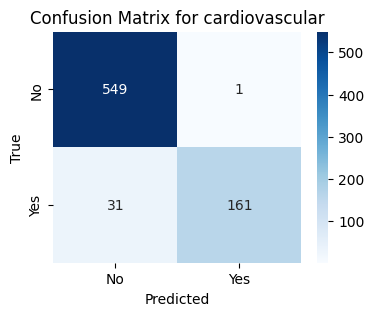

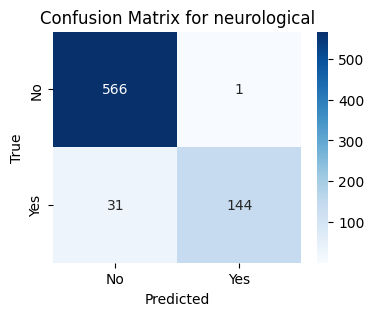

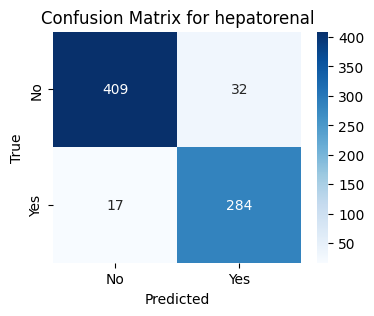

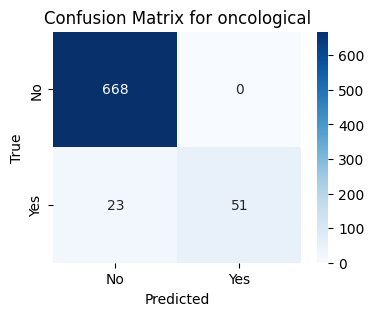

In [207]:
mcm = multilabel_confusion_matrix(y_test,y_pred)
for i, label in enumerate(valid_groups):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

## Save model

In [208]:
import pickle

# Guardar en un archivo .pkl
with open("linearsvc_model.pkl", "wb") as f:
    pickle.dump(svc_clf, f)
